In [1]:
import numpy as np
import pandas as pd

from eunjeon import Mecab; mecab = Mecab()
from sklearn.feature_extraction.text import TfidfVectorizer

from wordcloud import WordCloud

import warnings
warnings.filterwarnings(action='ignore')

### Function

In [2]:
# Functions to extract only nouns, remove one letter words, and remove stopwords from the dataframe.
def text_process(contents):
    # 불용어 목록 가져오기
    file = open('./dataset/stopwords.txt', 'r', encoding='UTF8')
    STOPWORDS = file.read().split(', ')
    file.close()
    
    # Get a list of more than 30 words.
    file = open('./dataset/gyeongju/min30.txt', 'r', encoding='utf-8')
    MINWORDS = file.read().split(',')
    file.close()
    
    # Dataframe to list
    content_list = [content for content in contents]
    
    # list to str type
    content_text = ''.join(content_list)
    
    # Morpheme analysis -> noun extraction.
    noun_list = mecab.nouns(content_text)
    
    # remove one letter words
    noun_list = [x for x in noun_list if len(x)>=2]
    
    # integrate
    for i in range(len(noun_list)):
        if(noun_list[i]=='경주시'):
            noun_list[i] = '경주' 
        
    # Remove words less than 30 times.
    noun_list = [word for word in noun_list if word in MINWORDS]
        
    # Remove the terminology and return
    return ' '.join([word for word in noun_list if word not in STOPWORDS])

In [3]:
# list to dictionary
def todict(list_tuple):    
    todict = {}
    for i in range(0,len(list_tuple)):
        todict[list_tuple[i][0]] = list_tuple[i][1]
    return todict

In [4]:
# dataframe to list
def tolist(df):
    return [tuple(r) for r in df.to_numpy()]

In [5]:
# Extract key words of the document in order of ranking through TF-IDF and return them to the list.
def getRankListFromSeries(s):
    clean_list = s.to_list()

    tfidf_vectorizer = TfidfVectorizer()
    tfidf_matrix = tfidf_vectorizer.fit_transform(clean_list)

    terms = tfidf_vectorizer.get_feature_names()

    sums = tfidf_matrix.sum(axis=0)

    data = []
    for idx, term in enumerate(terms):
           data.append( (term, sums[0, idx] ))

    ranking_df = pd.DataFrame(data, columns=['term','rank'])
    ranking_df.sort_values('rank',inplace=True, ascending=False)
    
    return tolist(ranking_df)

In [6]:
# graph visualization
def visualize(x, xlabel, ylabel, figsize=(10,5), flag=False, bent=3, minlimit=0.003, 
              maxlimit=0.003, order=0, filename="visualize", filedir="",isSaved=False):
    from matplotlib import pyplot
    from scipy.signal import savgol_filter

    pyplot.figure(figsize=figsize)

    pyplot.rcParams['font.family'] = 'Malgun Gothic'
    pyplot.rcParams['axes.unicode_minus'] =False
    pyplot.rcParams['font.size'] = 15
    
    pyplot.ylabel('Probability')
    
    if flag: # 토픽 내 단어 그래프인 경우   
        for e in range(len(ylabel)):
            xfilter = savgol_filter(x[e], len(x[e]), bent)
            xfilter[xfilter<0] = 0
            pyplot.plot(xfilter, label=ylabel[e], linewidth=4)
        
        pyplot.legend(title='Words', loc='upper left', shadow=True, bbox_to_anchor=(1.05, 1))
        
    else: # 토픽그래프인 경우
        for e in range(numOfTopics):
            xfilter = savgol_filter(x[e], len(x[e]), bent)
            xfilter[xfilter<0] = 0
            pyplot.plot(xfilter, label=ylabel[e], linewidth=4)
        
        pyplot.legend(title='Topics', loc='upper left', shadow=True, bbox_to_anchor=(1.05, 1))

    pyplot.xlim(0, len(time_slice)-1)
    pyplot.ylim(min(map(min, x)) - minlimit, max(map(max, x)) + maxlimit)

    x = list(range(0, len(xlabel)))
    pyplot.xticks(x, xlabel)
    
    pyplot.tight_layout()
    pyplot.grid()   
    
    if isSaved:
        pyplot.savefig(filedir + filename + '.png')
 
    pyplot.show()

In [7]:
# insert data into dataframe
def insert_row(idx, df, df_insert):
    idx = idx-2004
    return df.iloc[:idx, ].append(df_insert).append(df.iloc[idx:, ]).reset_index(drop = True)

In [8]:
def createFolder(directory):
    import os
    
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSError:
        print ('Error: Creating directory. ' +  directory)

------------------------------------------------------------------------

### Load Dataset

In [9]:
model_file_name = "gyeongju_model"
city_name = "gyeongju"
dataset_path = "./dataset/" + city_name + "/naverview_" + city_name + ".xlsx"
image_path = "./dataset/" + city_name + "/image/" + model_file_name + "/"
topic_path = "./dataset/" + city_name + "/topic/"
createFolder(image_path)

In [10]:
data_df = pd.read_excel(dataset_path, engine="openpyxl")
data_df.head()

,title,nickname,datetime,content
0,경주맛집 - 참가자미회가 맛있는 양지식당,머시블루\n(mercyblu),2010. 11. 1. 11:19,경주하면 도시 전체가 유적지여서 차분히 볼거리가 많고 번잡하지 않고\n고즈넉하여 돌...
1,동화 같던 경주 스위트 메종 호텔 산책로,하나\n(louismom),2010. 12. 1. 12:10,한적하고 평화로운 경주의 산책로는 아직 끝나지 않았다.\n어쩜 이렇게 좋을까.\...
2,경주 남산 불곡 석불좌상 [경주여행/경주남산],까칠한포에버쥔장\n(papalagi2),2010. 10. 16. 9:06,1963년 1월 21일 보물 제198호로 지정되었다.\n이 불상은 경주남산 동쪽 ...
3,경주 맛집 - 숙영식당 (찰보리밥 + 파전),윈드보이\n(wind3202),2010. 5. 14. 0:00,"경주에서 마지막 식사를 한곳 숙영식당..\n원래는 매운탕집을 갈 예정이었으나, 황남..."
4,나홀로 경주 스쿠터여행 [1],옐로산도\n(kiyunm),2010. 5. 6. 19:54,연차를 내고.. 나 홀로 떠난 1박2일의 경주여행.\n그 흔한 수학여행으로도 가본적...


### Cleansing

In [11]:
data_df['title'] = data_df['title'].astype('str')
data_df['content'] = data_df['content'].astype('str') # string data로 변환

In [12]:
data_df['clean_title'] = data_df.title.apply(text_process)
data_df['clean_datetime'] = data_df['datetime'].str[:4]
data_df['clean_content'] = data_df['clean_title'] + " " + data_df.content.apply(text_process)

In [13]:
data_df = data_df.sort_values(by=['clean_datetime'], axis=0) # 정렬

In [14]:
idx = data_df[data_df['clean_datetime'].str.find("시간") != -1].index
data_df = data_df.drop(idx)

In [15]:
# 2004 ~ 2020
data_df = data_df[data_df['clean_datetime'] != '2003']
data_df = data_df[data_df['clean_datetime'] != '2021']

In [16]:
data_df.head()

,title,nickname,datetime,content,clean_title,clean_datetime,clean_content
8775,자동차 경주 ^^,티뷰\n(benzbmw),2004. 1. 17. 0:36,즐겨보는 스포츠 경기 있으세요? 전 주로 TV로 축구나 테니스 경기를 즐겨보는 편이...,자동차 경주,2004,자동차 경주 스포츠 경기 축구 경기 관람 스포츠 경기도 얘기 카레 경주 방송 관련 ...
8774,경주2,진혜\n(23nov76),2004. 8. 12. 11:48,웃기지만 경주에서 첫식사는\n그지역의 맛집이 아닌 호텔 부페였다-\n 먹으러 ...,경주,2004,경주 경주 식사 지역 맛집 호텔 부페 할인 부페 고고 연어 보문 단지 유명 물레방아...
8773,경주나들이,유니콘\n(herb0119),2004. 12. 20. 21:25,경주는 가기는 갔는데...\n어딘지....\n높은곳이였는데....\n그 근처에 내리...,경주 나들이,2004,경주 나들이 경주 어딘지 디카
8772,경주 산책....^^,썸바디\n(whereugo),2004. 12. 23. 20:12,확실히 경상남도와 경상북도는 기온차가 났어요.\n울산은 그다지 춥지 않았는데\n경주...,경주 산책,2004,경주 산책 경상북도 기온 울산 경주 사람
8771,"경주, 부산 먹거리",참 삶\n(oilbanco),2004. 9. 10. 18:03,경주는 특별히 유명한 음식이나 식당이 있는것이 아니다.\n그러나 이 지역에서 함...,경주 부산 먹거리,2004,경주 부산 먹거리 경주 유명 음식 식당 지역 가지 추천 쌈밥 천마총 관람 삼포 밥상...


### Load model

In [17]:
from gensim.models import LdaSeqModel
from gensim import corpora
import gensim
from tqdm import tqdm
from gensim.test.utils import datapath

In [18]:
# load DTM model
temp_file = datapath(model_file_name)
ldaseq = LdaSeqModel.load(temp_file)

In [19]:
# set variables
numOfTerms = 100 # 토픽 내 단어수
numOfTopics=len(ldaseq.print_topics(top_terms=numOfTerms)) # 토픽의 수
time_slice = list(data_df.groupby('clean_datetime').count()['title'].values) # 타임 슬라이스 (1년단위)
year_list = [year for year in range(2004, 2021)]

### Generate Topic Dataframe

In [20]:
topic_df = pd.DataFrame(columns=['단어', '토픽', '연도', '단어수', '연도내총단어수', '토픽영향력', '단어비율'])

for y in tqdm(range(len(time_slice))): # 연도
    # 토픽모델링 - 연도 내 토픽 목록 생성
    topics_list = ldaseq.print_topics(time=y, top_terms=numOfTerms)
    
    # 데이터셋에서 연도 내 단어 목록 생성
    text_list = data_df[data_df['clean_datetime']==str(2004+y)]['clean_content'].values #2004+y년도 게시글 목록
    term_list = ' '.join(text_list).split(" ") # 해당 연도 단어 목록 ['aaa', 'bbb', 'ccc', 'ddd', 'eee', 'fff']
    
    for i in range(numOfTopics): # 토픽의 수
        for j in range(numOfTerms): # 한 토픽 내 총 단어 수
            word = topics_list[i][j][0] # 단어
            if len(word)==0: continue # 단어가 비었으면 넘어가기
            topic = i+1 # 토픽
            year = 2004+y  # 연도            
            numword = term_list.count(word) # 단어수
            totalword = len(term_list) # 연도내총단어수
            impact = topics_list[i][j][1] # 토픽영향력
            wordratio = numword/totalword # 단어비율 (단어수/연도내총단어수)
            topic_df.loc[len(topic_df)] = [word, topic, year, numword, totalword, impact, wordratio]

topic_df.to_excel(topic_path + model_file_name + "_topic.xlsx")
topic_df.head()

100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:46<00:00,  2.76s/it]


,단어,토픽,연도,단어수,연도내총단어수,토픽영향력,단어비율
0,경주,1,2004,2678,61328,0.051631,0.043667
1,황남빵,1,2004,57,61328,0.020597,0.000929
2,식당,1,2004,47,61328,0.019276,0.000766
3,쌈밥,1,2004,49,61328,0.013926,0.000799
4,음식,1,2004,47,61328,0.011846,0.000766


In [21]:
# Calculate the proportion of words.
wordRtInYrs_list = []
for y in range(len(time_slice)):
    text_list = data_df[data_df['clean_datetime']==str(2004+y)]['clean_content'].values
    term_list = ' '.join(text_list).split(" ") # ['aaa', 'bbb', 'ccc', 'ddd', 'eee', 'fff']

    tmp_list = []
    for i in range(numOfTopics):
        word_list = list(set(topic_df[topic_df['토픽'] == (i+1)]['단어'].values))
        tmp_list.append(sum([term_list.count(i) for i in word_list]) / len(term_list)) # i+1번 토픽 내 단어들이 2004+y년도 게시글 단어 목록에서 몇개나 되는지 비율
    wordRtInYrs_list.append(tmp_list)

wordRtInYrs_list = np.array(wordRtInYrs_list).T

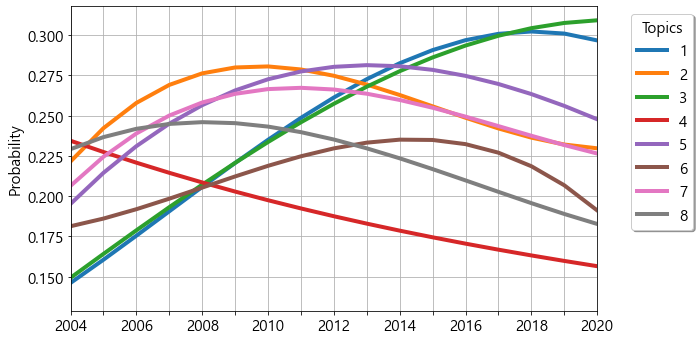

In [22]:
xlabel = ['2004', '', '2006','', '2008','', '2010','', '2012','', '2014','', '2016','', '2018','', '2020']
ylabel = ['1', '2', '3', '4', '5', '6', '7', '8', '9']

visualize(wordRtInYrs_list, xlabel, ylabel, minlimit=0.02, maxlimit=-0.02, 
          bent=3, isSaved=False, filename="topic", filedir=image_path)

In [23]:
import collections

word_list = []
word_score = []
for i in range(numOfTopics):
    word_in_topic_list = topic_df[topic_df['토픽'] == (i+1)]['단어'].values
    counts = collections.Counter(word_in_topic_list)
    counts = sorted(counts.items(), key=lambda x: x[1], reverse=True)
    
    tfidf_list = getRankListFromSeries(data_df['clean_content'])[:100] # tf-idf
    tfidf_word_list = [word[0] for word in tfidf_list] #tf-idf
    
    word_remove_list = ['경주']
    
    word_in_topic_list = [word[0] for word in counts if word[0] not in word_remove_list][:100] # 연도별 토픽에서 가장 많이 언급된 상위 100개
    word_in_topic_list = [word for word in word_in_topic_list if word in tfidf_word_list] #tf-idf
    word_in_topic_list = word_in_topic_list[:10]# 단어는 최대 10개까지만
    
    for j in range(len(word_in_topic_list)):
        tmp_topic_df = topic_df[(topic_df['단어'] == word_in_topic_list[j]) & (topic_df['토픽'] == (i+1))]

        no_year_list = [year for year in year_list if year not in tmp_topic_df['연도'].values]

        tmp_list = tmp_topic_df.iloc[0]
        tmp_list[3] = 0
        tmp_list[4] = 0
        tmp_list[5] = 0
        tmp_list[6] = 0

        for year in no_year_list:
            tmp_list[2] = year
            tmp_topic_df = insert_row(year, tmp_topic_df, tmp_list)

        word_score.append(list(tmp_topic_df['토픽영향력'].values))
    word_list.append(word_in_topic_list)

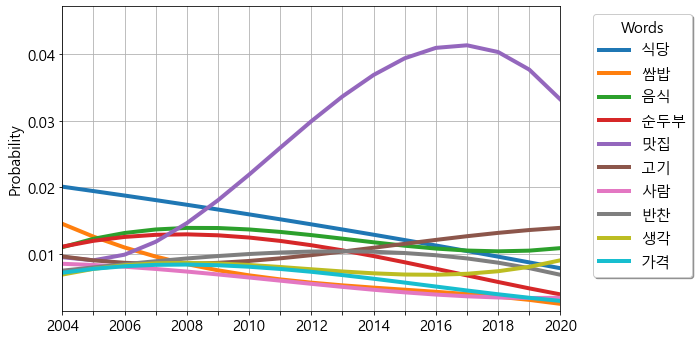

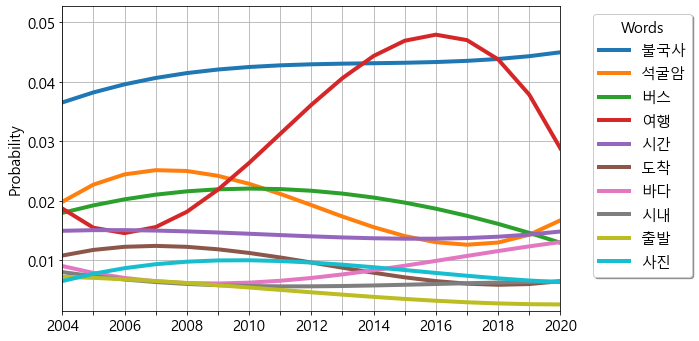

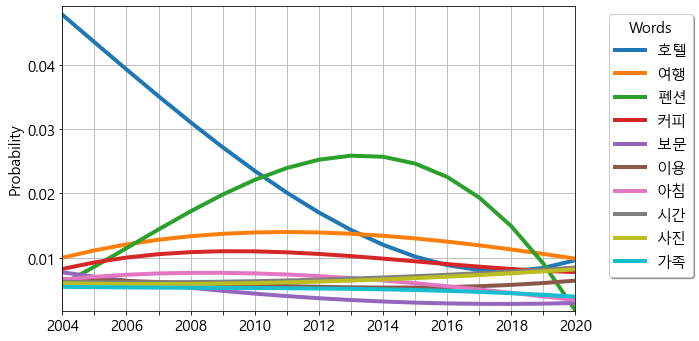

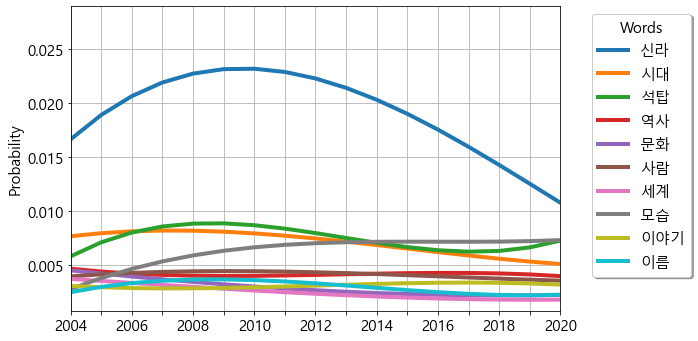

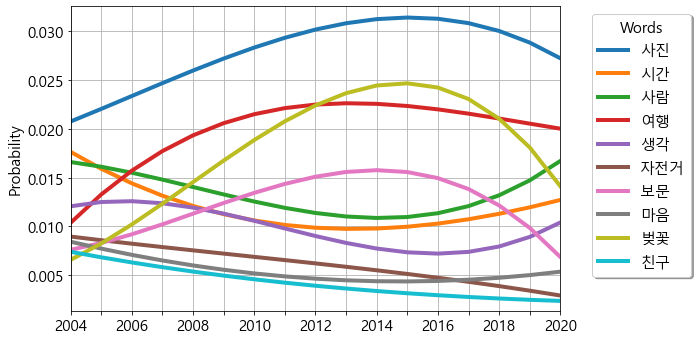

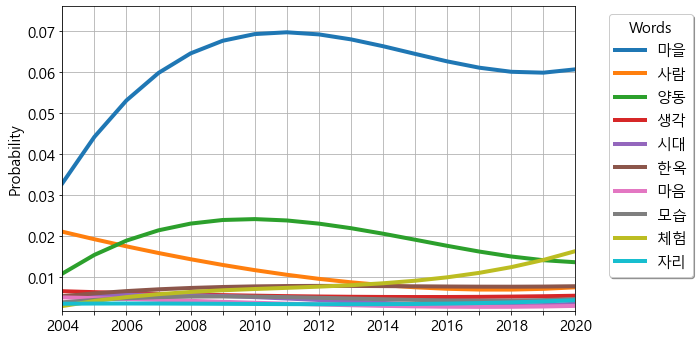

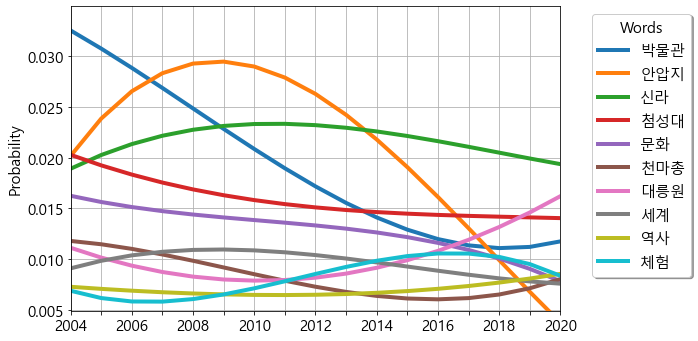

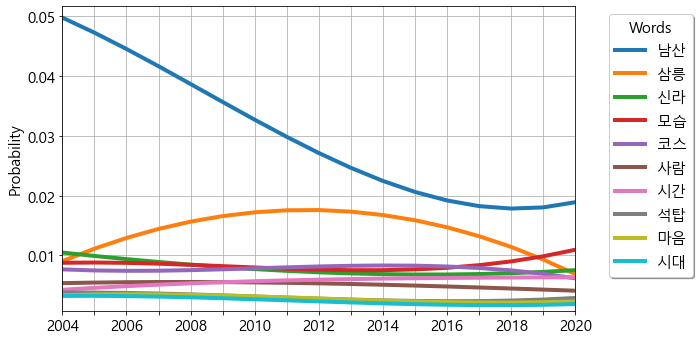

In [24]:
xlabel = ['2004', '', '2006','', '2008','', '2010','', '2012','', '2014','', '2016','', '2018','', '2020']

idx = 0
for i in range(numOfTopics):
    ylabel = word_list[i]
    
    length_list = [len(word_list[idx]) for idx in range(len(word_list))]
    
    x = word_score[idx : idx+length_list[i]]
    idx = idx + length_list[i]

    visualize(x, xlabel, ylabel, flag=True, bent=3, isSaved=False,
              minlimit=0.001, maxlimit=0.001, order=i, filedir=image_path, filename="words" +str(i+1))